<a href="https://colab.research.google.com/github/urieliram/statistical/blob/main/Tarea6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import operator
import matplotlib
from statsmodels.nonparametric.smoothers_lowess import lowess
from mpl_toolkits.mplot3d import Axes3D # Axes3D import has side effects, it enables using projection='3d' in add_subplot
from math import ceil
from scipy import linalg
from os import listdir
from numpy.linalg import *
from scipy.stats.stats import pearsonr
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import statsmodels.tools.eval_measures as bias
import statsmodels.api as sm
from sklearn.neighbors import KernelDensity
from statsmodels.nonparametric.kernel_regression import KernelReg

# Regresión local en $\mathcal{Rp}$

Se implementa el método de regresión (lineal) local con suavización con kernel en multiples dimensiones $p$ en cada punto de una variable dependiente.

La implementación fue realizada basada en las consideraciones del libro [The Elements of Statistical Learning](https://link.springer.com/book/10.1007/978-0-387-84858-7) secciones; 6.1 One-Dimensional Kernel Smoothers; 6.1.1 Local Linear Regression; y 6.3 Local Regression in IRp.

## Un ejemplo sencillo de regresión local en $\mathcal{Rp}$  con pocos datos
Los datos usados en esta sección están disponibles en [minitest.csv](https://drive.google.com/file/d/10Shxgajmm_loJf_3PrD6rQBF6-UqEOH3/view?usp=sharing)

In [30]:
df  = pd.read_csv('minitest.csv')
X   = pd.DataFrame(df[['X1','X2','X3']]).to_numpy()
Y   = pd.DataFrame(df[['Y']]).to_numpy()

Iniciamos calcuando los pesos de los puntos $x_i\in\mathcal{Rp}$ del vecindario alrededor del punto $x_o\in\mathcal{Rp}$.

Damos mayor peso a las puntos $x_i$ mas cercanos al punto $x_o$ y menos peso a las observaciones más lejanas. 
Calcularemos los pesos de los puntos utilizando un kernel que asigna importancia a cada uno de los k vecinos de $x_i$ según su distancia a $x_o$.

In [31]:
# Calcula los pesos y regresa una matriz diagonal con los pesos
def get_weight_exp(xo, X, k): 
## k    : tamanio del vecindario (bandwidth)
## X    : Regresores
## xo   : punto donde se desea hacer la predicción.

    n = X.shape[0]             ## numero de datos
    weight = np.mat(np.eye(n)) ## Matriz de pesos identidad W.
    
  # Cálculo de pesos para todos los datos de entrenamiento xi.
    for i in range(n): 
        xi = X[i] 
        d = (-2 * k * k) 
        weight[i, i] = np.exp(np.dot((xi-xo), (xi-xo).T)/d) 
        
    return weight

In [32]:
# Otro kernel para calcular pesos y regresa una matriz diagonal con los pesos
def get_weight_NN(xo, X, k): 
## k    : tamanio del vecindario (bandwidth)
## X    : Regresores
## xo   : punto donde se desea hacer la predicción.

    n = X.shape[0]             ## numero de datos
    weight = np.mat(np.eye(n)) ## Matriz de pesos identidad W.
    
  # Cálculo de pesos para todos los datos de entrenamiento xi.
    for i in range(n): 
        xi    = X[i] 
        aux   = (xo-xi)
        aux   = pow(aux,2)
        suma  = np.sum(aux)
        weight[i, i] = pow(suma,(1/2))
        suma   = np.sum(weight)        
        weight = weight/suma
    return weight

A continuación estimamos los coeficientes de regresión `β = (Xt W(xo) X)^{-1}) (Xt W Y)`

In [33]:
def local_regression(X,W,Xo):
    # W     --> Matriz diagonal de pesos
    # X     --> Regresores
    # xo    --> punto donde se desea hacer la predicción.
    Xt = X.T  # Calcula transpuesta de X
    A = np.matmul(Xt, np.matmul(W,X)) 
    A = np.linalg.inv(A)   # Calcula inversa de A
    B = np.matmul(Xt, np.matmul(W,Y)) 
    beta = np.matmul(A,B)
    prediccion = np.matmul(Xo,beta)
    return prediccion

En esta función se recorre uno a uno los puntos de la función de `X_test` para calcular la predicción. Es decir, para cada uno de los datos, seleccionaremos una vecindad de k puntos muestreados y los usaremos como conjunto de entrenamiento para un problema de regresión lineal con pesos. Aunque ajustamos un modelo lineal completo a los datos de la vecindad, solamente lo usamos para evaluar el ajuste en el único punto `xo`.

In [34]:
k = 3 # Tamanio del vecindario #17 #25 #50

Y_local = []
for i in range(X.shape[0]):
    xo = X[[i]]
    W = get_weight_exp(xo, X, k)
    #W = get_weight_NN(xo, X, k)
    Ygorro = local_regression(X, W, xo)
    Y_local.append(Ygorro.item(0))

En esta sección calculamos la predicción usando unicamente la regresión lineal múltiple. Como se observa los pesos `W` son la matriz identidad.

In [35]:
Y_pred = []
for i in range(X.shape[0]):
    xo = X[[i]]
    W = np.mat(np.eye(X.shape[0])) 
    Ygorro = local_regression(X, W, xo)
    Y_pred.append(Ygorro.item(0))

No handles with labels found to put in legend.


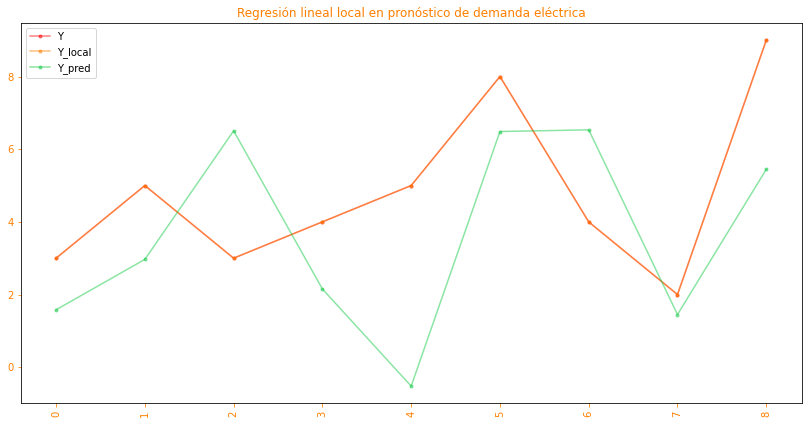

In [36]:
fig  = plt.figure(figsize=(14,7))
axes = fig.add_subplot(1, 1, 1)
#plt.style.use("seaborn-poster")
axes.legend()
CYAN = '#76ced6' ; LILA = '#777bd4'; VERDE='#17cb49'; LETRASNARA ='#ff8000'; AZUL='#168fff';
mytitle = plt.title('Regresión lineal local en pronóstico de demanda eléctrica') # get the title property handler #plt.getp(title_obj)
plt.setp(mytitle,    color=LETRASNARA)                                        #set the color of title to red
axes.xaxis.label.set_color(LETRASNARA)
axes.yaxis.label.set_color(LETRASNARA)
axes.tick_params(   colors=LETRASNARA, which='both')

axes.plot ( Y      , '.-'  , color = 'red'        , label = 'Y'  ,alpha=1/2)
axes.plot  ( Y_local, '.-'  , color = LETRASNARA   , label = 'Y_local'  ,alpha=1/2)
axes.plot  ( Y_pred , '.-'  , color = VERDE , label = 'Y_pred'  ,alpha=1/2)
#axes.plot ( xspline[3], yspline[3] , '.-'  , color = VEDE   , label = 'orden=4'  ,alpha=1/2)
#axes.plot ( xspline[4], yspline[4] , '.-'  , color = AZUL   , label = 'orden=5'  ,alpha=1/12)
#AUX = np.arange( len(Y) )
#plt.scatter( AUX,    Y,     s=25 ,  marker='o' , color = 'red'   , label = 'X'        ,alpha=1)
#plt.scatter( dfx_miss, dfy_miss, marker='x',  s=170 ,  color = 'red' , label = 'perdidos' ,alpha=1)

#plt.axis([0,  600, 7400, 9800])
#plt.axis([150, 300, 7400, 9800])
plt.legend()  
plt.xticks(rotation=90)
plt.savefig('pronodemanda_t6_1.png', transparent=True)
plt.show()

## Regresión local en $\mathcal{Rp}$ en predicción de demanda eléctrica

A continuación haremos la comparación de resultados de regresión para datos de demanda eléctrica. La variable independiente $X$ serán los datos de demanda del día anterior, y los datos independiente $Y$ serán los datos de días con una mayor correlación con $X$. En esta sección, aplicaremos técnicas de regresión local con multiples regresores X.

Los datos usados en esta sección están disponibles en [demanda.csv](https://drive.google.com/file/d/1KpY2p4bfVEwGRh5tJjMx9QpH6SEwrUwH/view?usp=sharing)

In [37]:
df    = pd.read_csv('demanda.csv')

## Procesamos datos de entrenamiento 
df1 = df.loc[df.iloc[:,19].isin(['T'])] ## 'T' = training set
df2 = df1['Y']  
df1 = df1[['X1','X2','X3','X4','X5','X6','X7','X8','X9','X10']] ## Regresores

X     = pd.DataFrame(df[['X1','X2']]).to_numpy() 
Y     = pd.DataFrame(df[['Y']]).to_numpy()

Ahora, cargamos los datos de prueba en los arreglos `X_train` y `y_train`:

In [38]:
## Procesamos datos de prueba 
dft = df.loc[df.iloc[:,19].isin(['F'])] ## 'F' = test set
dft2 = dft['Y']
dft1 = dft[['X1','X2','X3','X4','X5','X6','X7','X8','X9','X10']] ## Regresores

Estandarizamos los datos de los regresores `X_train` y `X_test` restando la media y dividiendo entre la varianza.

In [39]:
df1.std(numeric_only = True) 
df1.mean(numeric_only = True)
df1 = df1 - df1.mean(numeric_only = True)
df1 = df1 / df1.std(numeric_only = True) 
X_train = df1.to_numpy()   ## Predictors
#X_train = sm.add_constant(X_train)
y_train = df2.to_numpy()   ## Outcome

In [40]:
dft1.std(numeric_only = True) 
dft1.mean(numeric_only = True)
dft1 = dft1 - dft1.mean(numeric_only = True)
dft1 = dft1 / dft1.std(numeric_only = True) 
X_test = dft1.to_numpy()   ## Predictors
#X_test = sm.add_constant(X_test)
y_test = dft2.to_numpy()   ## Outcome

En esta función se recorre uno a uno los puntos de la función de `X_test` para calcular la predicción. Es decir, para cada uno de los datos, seleccionaremos una vecindad de k puntos muestreados y los usaremos como conjunto de entrenamiento para un problema de regresión lineal con pesos. Aunque ajustamos un modelo lineal completo a los datos de la vecindad, solamente lo usamos para evaluar el ajuste en el único punto `xo`. 

In [41]:
k = 0 # Tamanio del vecindario
klist = [17,25,35,50,100]
Y_local_list = []
for item in klist:
    k = item
    Y_local = []
    for i in range(X.shape[0]):
        xo = X[[i]]
        W = get_weight_exp(xo, X, k)
        Ygorro = local_regression(X, W, xo)
        Y_local.append(Ygorro.item(0))
    Y_local_list.append(Y_local)

En esta sección calculamos la predicción usando unicamente la regresión lineal múltiple. Como se observa en este caso los pesos `W` son la matriz identidad.

In [42]:
Y_pred = []
for i in range(X.shape[0]):
    xo = X[[i]]
    W = np.mat(np.eye(X.shape[0])) 
    Ygorro = local_regression(X, W, xo)
    Y_pred.append(Ygorro.item(0))

Calculamos los errores de los métodos de regresión comparados, variando además los tamaños de las vecindades `k`.

In [43]:
def trunc(values, decs=0):
    return np.trunc(values*10**decs)/(10**decs)

In [44]:
mae_pred  = trunc(mean_absolute_error(Y,Y_pred),4)
mae_local_k0 = trunc(mean_absolute_error(Y,Y_local_list[0]),4)
mae_local_k1 = trunc(mean_absolute_error(Y,Y_local_list[1]),4)
mae_local_k2 = trunc(mean_absolute_error(Y,Y_local_list[2]),4)
mae_local_k3 = trunc(mean_absolute_error(Y,Y_local_list[3]),4)
mae_local_k4 = trunc(mean_absolute_error(Y,Y_local_list[4]),4)

In [45]:
mse_pred  = trunc(mean_squared_error(Y,Y_pred),4)
mse_local_k0 = trunc(mean_squared_error(Y,Y_local_list[0]),4)
mse_local_k1 = trunc(mean_squared_error(Y,Y_local_list[1]),4)
mse_local_k2 = trunc(mean_squared_error(Y,Y_local_list[2]),4)
mse_local_k3 = trunc(mean_squared_error(Y,Y_local_list[3]),4)
mse_local_k4 = trunc(mean_squared_error(Y,Y_local_list[4]),4)

In [46]:
mape_pred  = trunc(mean_absolute_percentage_error(Y,Y_pred),4)
mape_local_k0 = trunc(mean_absolute_percentage_error(Y,Y_local_list[0]),4)
mape_local_k1 = trunc(mean_absolute_percentage_error(Y,Y_local_list[1]),4)
mape_local_k2 = trunc(mean_absolute_percentage_error(Y,Y_local_list[2]),4)
mape_local_k3 = trunc(mean_absolute_percentage_error(Y,Y_local_list[3]),4)
mape_local_k4 = trunc(mean_absolute_percentage_error(Y,Y_local_list[4]),4)

print('| REGRESIÓN      | MAE            | MSD            | MAPE         |')
print('| :------------- | -------------: | -------------: |-------------:|')
print('|    lineal      |',str(mae_pred),'    |',str(mse_pred),'   |   ',str(mape_pred),'|')
print('| local K1, k=17 |',str(mae_local_k0),'   |',str(mse_local_k0),'   |   ',str(mape_local_k0),'|')
print('| local K1, k=25 |',str(mae_local_k1),'   |',str(mse_local_k1),'   |   ',str(mape_local_k1),'|')
print('| local K1, k=35 |',str(mae_local_k2),'   |',str(mse_local_k2),'   |   ',str(mape_local_k2),'|')
print('| local K1, k=50 |',str(mae_local_k3),'   |',str(mse_local_k3),'   |   ',str(mape_local_k3),'|')
print('| local K1, k=100|',str(mae_local_k4),'   |',str(mse_local_k4),'   |   ',str(mape_local_k4),'|')

| REGRESIÓN      | MAE            | MSD            | MAPE         |
| :------------- | -------------: | -------------: |-------------:|
|    lineal      | 138.5861     | 32615.1951    |    0.0159 |
| local K1, k=17 | 68.3866    | 51771.7855    |    0.0078 |
| local K1, k=25 | 83.5068    | 14118.722    |    0.0096 |
| local K1, k=35 | 98.6564    | 18483.2236    |    0.0113 |
| local K1, k=50 | 109.6632    | 21942.6356    |    0.0126 |
| local K1, k=100| 123.9285    | 26331.6078    |    0.0142 |


Graficamos los resultados de predicción de la regresión local con k= [17,25,35,50] y regresión local para pronosticar los datos de prueba `Y`.

No handles with labels found to put in legend.


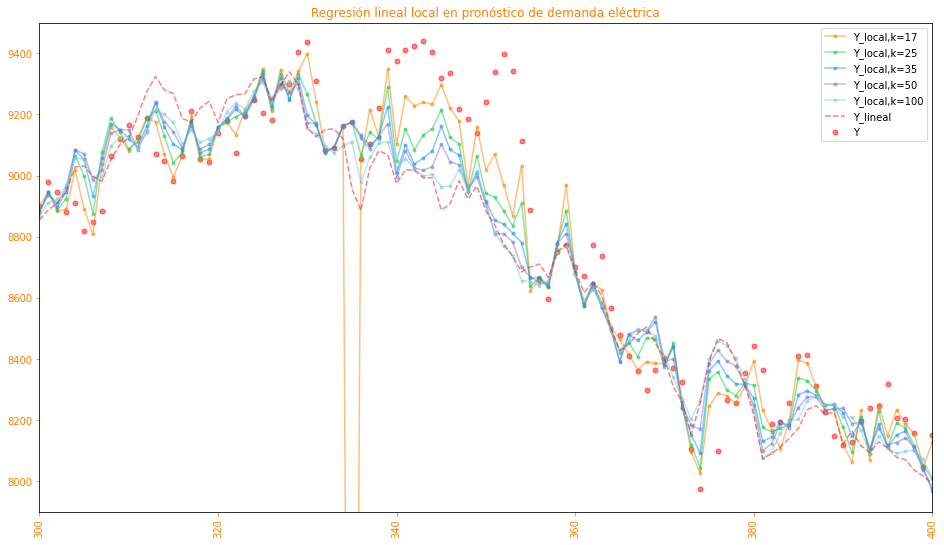

In [65]:
fig  = plt.figure(figsize=(16,9))
axes = fig.add_subplot(1, 1, 1)
#plt.style.use("seaborn-poster")
axes.legend()
CYAN = '#76ced6' ; LILA = '#777bd4'; VERDE='#17cb49'; LETRASNARA ='#ff8000'; AZUL='#168fff';
mytitle = plt.title('Regresión lineal local en pronóstico de demanda eléctrica') # get the title property handler #plt.getp(title_obj)
plt.setp(mytitle,    color=LETRASNARA)                                        #set the color of title to red
axes.xaxis.label.set_color(LETRASNARA)
axes.yaxis.label.set_color(LETRASNARA)
axes.tick_params(colors=LETRASNARA, which='both')

AUX = np.arange( len(Y) )
plt.scatter( AUX,Y,s=25,marker='o' , color = 'red'      , label = 'Y'              ,alpha=1/2)
axes.plot  ( Y_local_list[0], '.-' , color = LETRASNARA , label = 'Y_local,k=17'   ,alpha=1/2)
axes.plot  ( Y_local_list[1], '.-' , color = VERDE      , label = 'Y_local,k=25'   ,alpha=1/2)
axes.plot  ( Y_local_list[2], '.-' , color = AZUL       , label = 'Y_local,k=35'   ,alpha=1/2)
axes.plot  ( Y_local_list[3], '.-' , color = LILA       , label = 'Y_local,k=50'   ,alpha=1/2)
axes.plot  ( Y_local_list[4], '.-' , color = CYAN     , label = 'Y_local,k=100'  ,alpha=1/2)
axes.plot  ( Y_pred         , '--' , color = 'red'       , label = 'Y_lineal'       ,alpha=1/2)
#axes.plot ( Y      , '.-'  , color = 'red'        , label = 'Y'  ,alpha=1/2)
#axes.plot ( Y_local, '.-'  , color = LETRASNARA   , label = 'Y_local'  ,alpha=1/2)
#axes.plot ( xspline[3], yspline[3] , '.-'  , color = VERDE   , label = 'orden=4'  ,alpha=1/2)
#axes.plot ( xspline[4], yspline[4] , '.-'  , color = AZUL   , label = 'orden=5'  ,alpha=1/12)
#plt.scatter( dfx_miss, dfy_miss, marker='x',  s=170 ,  color = 'red' , label = 'perdidos' ,alpha=1)

#plt.axis([0,  600, 7400, 9800])
#plt.axis([100,  200, 7650, 9500])
#plt.axis([400,  500, 7650, 9500])
#plt.axis([-2,  100, 8100, 9600])
plt.axis([300, 400, 7900, 9500])
plt.legend()  
plt.xticks(rotation=90)
plt.savefig('pronodemanda_t6_4.png', transparent=True)
plt.show()

In [48]:
def dibuja_hist(df,colour,name,Xlabel,Ylabel,title):
    plt.figure()
    df.hist(column=0, bins=25, grid=False, figsize=(6,3), color=colour, zorder=2, rwidth=0.9)
    plt.xticks(rotation=90)
    plt.xlabel(Xlabel)
    plt.ylabel(Ylabel)
    #https://stackoverflow.com/questions/9662995/matplotlib-change-title-and-colorbar-text-and-tick-colors/42020486
    mytitle = plt.title(title) # get the title property handler   #plt.getp(title_obj)  
    plt.setp(mytitle, color='#ff8000')                            # set the color of title
    myax = plt.axes()   # get the axis property handler           # plt.getp(myax) print its propieties
    myax.xaxis.label.set_color('#ff8000')
    myax.yaxis.label.set_color('#ff8000')
    myax.tick_params(colors='#ff8000', which='both')              # myax.spines['bottom'].set_color('yellow')
    plt.savefig(name, transparent=True)
    plt.show()   

## Algunas ligas útiles que se utilizaron se pueden encontrar aquí
* [Locally weighted linear Regression using Python](https://www.geeksforgeeks.org/locally-weighted-linear-regression-using-python/)*   
* [Kernel regression estimation](https://bookdown.org/egarpor/NP-UC3M/kre-i-kre.html)
* [Kernel Density Estimation and Non-Parametric Regression](https://towardsdatascience.com/kernel-density-estimation-and-non-parametric-regression-ecebebc75277) 
* [Libreria localreg](https://github.com/sigvaldm/localreg) 
* [tips-locally-weighted-linear-regression](https://www.kaggle.com/alincijov/tips-locally-weighted-linear-regression)

* [LOESS Smoothing data using local regression](https://towardsdatascience.com/loess-373d43b03564)
*  [LOWESS Smoother, STATSMODELS](https://www.statsmodels.org/dev/examples/notebooks/generated/lowess.html)
*   https://www.allendowney.com/blog/2019/04/01/local-regression-in-python/
*   https://www.geeksforgeeks.org/implementation-of-locally-weighted-linear-regression/
*   https://towardsdatascience.com/locally-weighted-linear-regression-in-python-3d324108efbf

**Conclusión tarea 6** El mejor ajuste de un modelo de regresión local siempre será el de punto por punto, con un modelo por punto.
Puede que el número de intervalos de corte o en este caso puntos query estén definidos.
Puede que además que se incluya el tamaño del vecindario de los intervalos.
En este caso estos son parámetros del modelo, sin embargo si estas son variables de decisión, el modelo se vuelve un problema de optimal binning, y es aplicado a discretización.
En cierto sentido, k es la perilla de sesgo frente a varianza. Los valores grandes de k darán como resultado un mayor sesgo y los valores más bajos inducirán una mayor varianza.

In [49]:
R= np.asarray([2,4,5,6,7,8,5,6,3,2,4,7,3,4,2,4,6,8,5,3,45,6,8,9,6,4,6,8,3,4,3,1,2,5,9,8,4,7,6,5,3,2,5,7,3,5,3,2,4,5,2,6,7,5,5])
import numpy as np
rng = np.random.RandomState(42)
R = rng.random_sample((100, 3))
kdeGauss = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(R)
log_density = kdeGauss.score_samples(R[:3])

kdeEspane = KernelDensity(kernel='epanechnikov', bandwidth=0.05).fit(R)
